In [1]:
from dataclasses import dataclass
import os
from dotenv import load_dotenv

load_dotenv()

@dataclass
class Config:
    # model configuration
    # base_model: str = "ollama_chat/qwen2.5:32b-instruct-q8_0"
    # base_model: str = "ollama_chat/gemma2:9b-instruct-q8_0"
    # base_model: str = "ollama_chat/llama3.2:1b-instruct-q8_0"
    # base_model: str = "ollama_chat/exaone3.5:2.4b-instruct-q8_0"
    # base_model: str = "ollama_chat/granite3.1-dense:2b-instruct-q8_0"
    # base_model: str = "ollama_chat/granite3.1-moe:3b-instruct-q8_0"
    # base_model:str = "ollama_chat/llama3.2:3b-instruct-q8_0"
    # base_model:str = "ollama_chat/gemma2:27b-instruct-q8_0"
    temperature: float = 1.0
    base_model: str = "openrouter/deepseek/deepseek-chat"
    # base_model: str = "openrouter/meta-llama/Llama-3.3-70B-Instruct-Turbo"
    teacher_model: str = "openrouter/qwen/qwen-2.5-72b-instruct"
    # teacher_model: str = "openrouter/qwen/qwq-32b-preview"
    teacher_temperature: float = 0.8

    # dataset
    dataset: str = "scidocs"

    # APIKEY (if using api for teacher)
    api_key: str | None = None


config = Config(
    api_key = os.environ["OPENROUTER_APIKEY"]
)

In [2]:
import dspy

# small, locally hosted base model
# lm = dspy.LM(config.base_model, api_base='http://localhost:11434', api_key='', temperature=config.temperature, cache=False)
lm = dspy.LM(config.base_model, api_key=config.api_key, temperature=config.temperature, cache=False)
dspy.configure(lm=lm)

# teacher model for instruction proposal
teacher_lm = dspy.LM(config.teacher_model, api_key=config.api_key)

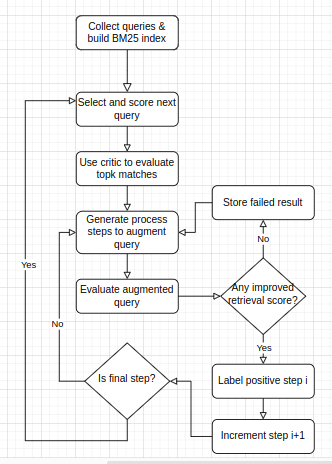

In [3]:
RESULTS_CRITIC = """
Using the query and the retrieved search results,
evaluate topics and/or terms covered by good results and poor results.

Think deeply about what the intention of the query is.
Describe what kind of data the results are (eg. medical documents, academic papers, articles, social media, etc.)

Finally, briefly discuss the strengths and weaknesses of the current results in answering the query.
"""

class CritiqueResults(dspy.Signature):
    __doc__ = RESULTS_CRITIC

    query: str = dspy.InputField(desc="The search query from the user")
    results: list[str] = dspy.InputField(desc="Top scored results retrived from the search")
    document_types: str = dspy.OutputField(desc="What kind of documents are in the index?")
    strengths_weaknesses: str = dspy.OutputField(desc="Strengths and weaknesses of results in answering query")

In [4]:
GENERATE_QUERY_AUGMENTATION = """
Your task is to enhance a given search query by discovering new, relevant documents across various domains.
The augmented query should be novel and free from overlapping the original terms.

### Guidelines:
- **Be Specific and Diverse:** Focus on targeted expansions that introduce new dimensions to the query.
- **Apply Varied Augmentation Techniques:**
  - Synonym Replacement, Conceptual Expansion, Contextual Expansion, Domain-Specific Terminology

### Task Structure:
Complete the following four tasks, avoiding generic or general statements.
Return specific task outcomes only, do not reiterate the task.
We are interested in the results, not the plan.

#### Task 1: Goal Elucidation & Gaps - Examine the original query to understand its primary objectives and gaps
#### Task 2: Ineffective Term Identification - List broad or non-precise terms that should be avoided
#### Task 3: Breadth Expansion - List candidate terms with increasingly distant concepts to the original query
#### Task 4: Depth Expansion - Choose one distant but important topic from the breadth expansion, and go increasingly deeper in the related terms on that one selection

### Final Output:
Return the `augmented_query` from the final task outcome, ensuring it contains only high-quality search terms:
- **No Logical Operators:** Do not use AND/OR.
- **Unique:** Include only unique words without duplication.
- **Diverse:** Target non-overlapping results from the original query.
- **Relevant:** Contextually or peripherally relevant to the original query.
- **Targeted:** Primarily terms from depth expansion with additional high-relevance terms
- **Precision:** Be certain to omit any ineffective words or terms, even if they are included used in the expanded terms.
"""


In [5]:
# GENERATE_QUERY_AUGMENTATION = """
# Your task is to create chain of thought steps, that augment the search query in order to improve results.
# Because the combined scoring is heavily weighted toward max scores, prioritize finding new documents over bolstering existing results.

# To accomplish this:
# - infer the objective or goals of the original query
# - utilize positive and negative information to guide augmentation
# - perform aggressive augmentation using the following techniques:
#     - Synonym (Replace words or phrases with synonyms)
#     - Paraphrase (Rephrase the query concisely, targeting better retrieval)
#     - Conceptual Overlap (Target alternative, but related concepts eg. higher or lower level, subset, superset or adjacent concepts)
#     - Contextual Meaning (Rephrase the query within the original context)


# Brainstorm the augmentation in 2-4 steps.
# Use this step-by-step format, producing specific, concrete and targeted reasoning:

# ## Step 1: [Concise description]
# ## Step 2: [Concise description]
# ...

# Remember, the augmented query will be used to query a BM25 index directly.
# Therefore, the augmented query should only contain high quality search terms (and no AND/OR).
# """
# GENERATE_QUERY_AUGMENTATION = """
# Your task is to create detailed steps that culminate in an augmentation of the search query.
# The should be concise, highly specific and transparently demonstrate the arrived upon query.
# Each task step should focus on surfacing new potential search terms and expanding to adjacent topics, omitting general statements.
# Each task step should contain explanation and specific expanded terms, expanding more distantly and deeply at each step for successful completion.
# Prioritize finding new documents over bolstering existing results, as the combined scoring is heavily weighted toward max scores.
# This entails that not all terms of the original query should be used.

# To accomplish this:
# - Avoid general statements
# - Use positive and negative topic information to guide augmentation
# - Identify terms that may be ambiguous or too non-specific for the query
# - Perform aggressive augmentation using the following techniques:
#     - Synonym or Semantic Replacement: Replace words or phrases with synonyms
#     - Paraphrasing: Rephrase the query concisely for better retrieval
#     - Conceptual Overlap: Target related concepts (e.g., higher or lower level, subset, superset, adjacent concepts)
#     - Contextual Meaning: Rephrase the query within its original context
#     - Domain-Specific Terminology: Add specialized jargon or acronyms pertinent to the query's field.
#     - Prioritize expansion with increasingly distant topics and exclusion of original terms (Important!)


# Complete the tasks, providing detailed, specific explanations, and avoiding generic or general statements:

# ## Task 1: [Your in-depth analysis of the intent and ambiguities of the original query. Predict the kind of data in the index.]
# ## Task 2: [Analysis of influence of document types and strengths and weaknesses of current results and how they should influence search terms]
# ## Task 3: [Numerous 1 or 2 word, increasingly distant topics, to create a pool for augmented term selection. Tree-like expansion]
# ## Task 4: [Specific topic term transitions (A->B) aggressively applying augmentation techniques]

# Finally, return the augmented query as a single string.
# Ensure the augmented query contains only high-quality search terms suitable for a sparse (BM25) index:
# - No AND/OR operators
# - Unique terms, no duplication
# - Omit identical terms to original query
# """
# GENERATE_QUERY_AUGMENTATION = """
# Your task is to develop a comprehensive, step-by-step process that results in an enhanced search query.
# The final augmented query should be concise, highly specific, and clearly reflect the refined search intent.

# Each step should focus on uncovering new search terms and expanding into related topics, avoiding general statements.
# Provide detailed explanations and specific expanded terms, progressively broadening the scope with each step to ensure effective query expansion.
# The objective is to prioritize discovering new documents over reinforcing existing results, as the scoring system heavily favors top-scoring documents.
# Therefore, not all original query terms need to be retained.

# ### Guidelines:
# - **Avoid General Statements:** Ensure all instructions and expansions are specific and targeted.
# - **Leverage Topic Information:** Use both positive and negative topic information to guide the augmentation process.
# - **Clarify Ambiguities:** Identify and refine terms that are ambiguous or too vague in the original query.
# - **Apply Aggressive Augmentation Techniques:**
#   - **Synonym or Semantic Replacement:** Substitute words or phrases with their synonyms.
#   - **Paraphrasing:** Rephrase the query succinctly to enhance retrieval effectiveness.
#   - **Conceptual Overlap:** Incorporate related concepts, such as higher or lower levels, subsets, supersets, or adjacent concepts.
#   - **Contextual Meaning:** Rephrase the query within its original context to maintain relevance.
#   - **Domain-Specific Terminology:** Introduce specialized jargon or acronyms pertinent to the query's field.
#   - **Expansion Priority:** Focus on expanding into increasingly distant topics while excluding original terms.

# ### Task Structure:
# Complete the following tasks with detailed and specific explanations, avoiding generic or general statements:

# #### Task 1: Analyze Intent and Ambiguities
# - **Objective:** Provide an in-depth analysis of the original query's intent and identify any ambiguities.
# - **Outcome:** Predict the type of data present in the index that the query is likely to retrieve.

# #### Task 2: Assess Document Types and Current Results
# - **Objective:** Examine the influence of different document types and evaluate the strengths and weaknesses of the current search results.
# - **Outcome:** Determine how these insights should influence the selection and modification of search terms.

# #### Task 3: Generate Potential Search Terms
# - **Objective:** Create a pool of numerous one or two-word terms representing increasingly distant topics using a tree-like expansion approach.
# - **Outcome:** Develop a diverse set of potential terms for augmented query selection.

# #### Task 4: Develop Topic Term Transitions
# - **Objective:** Establish specific transitions between topic terms (e.g., A → B) by aggressively applying augmentation techniques.
# - **Outcome:** Formulate a refined set of expanded terms that effectively broaden the original query.

# ### Final Output:
# Return the augmented query as a single string, ensuring it contains only high-quality search terms suitable for a sparse (BM25) index:
# - **No Logical Operators:** Do not use AND/OR operators.
# - **Unique Terms:** Include unique, targeted terms without duplication.
# - **Exclude Original Terms:** Omit any terms that are identical to those in the original query.
# """
# GENERATE_QUERY_AUGMENTATION = """
# Your will use a step-by-step process that enhances a search query by completing a set of tasks.
# The augmented query should be designed to discover new, unseen results using a sparse search index.

# ### Guidelines:
# - **Be Specific:** Avoid general statements and focus on targeted expansions.
# - **Apply Augmentation Techniques:**
#   - **Synonym Replacement:** Substitute words or phrases with synonyms.
#   - **Paraphrasing:** Rephrase the query for clarity and effectiveness.
#   - **Conceptual Expansion:** Include related concepts, such as broader or narrower terms.
#   - **Contextual Rephrasing:** Adjust the query within its original context to maintain relevance.
#   - **Domain-Specific Terms:** Apply relevant specialized jargon or acronyms.
#   - **Progressive Expansion:** Expand into increasingly distant topics.

# ### Task Structure:
# Complete the following tasks:

# #### Task 1: Analyze Intent and Ambiguities
# - **Objective:** Examine the original query's intent and identify any ambiguous or unclear terms.
# - **Outcome:** A set of candidate goals for the original query and ineffective search terms.

# #### Task 2: Assess Document Types and Current Results
# - **Objective:** Evaluate the types of documents returned by the current query and identify their strengths and weaknesses.
# - **Outcome:** Explanation of how these insights should influence the selection and modification of search terms.

# #### Task 3: Generate Potential Search Terms
# - **Objective:** Create a diverse pool of one or two-word terms representing related and increasingly distant topics.
# - **Outcome:** A set of potential candidate terms for selecting augmented query terms.

# #### Task 4: Develop Topic Term Transitions
# - **Objective:** Establish specific transitions between topic terms (e.g., A->B) by applying augmentation techniques aggressively.
# - **Outcome:** A refined set of expanded terms that effectively broaden the original query.

# ### Final Output:
# Return the augmented query, using high-quality search terms suitable for a sparse index:
# - **No Logical Operators:** Do not use AND/OR.
# - **Unique Terms:** Include only unique terms without duplication.
# - **Exclude Original Terms:** Omit any terms from the original query.
# - **Non-overlapping Results:** Augmented query targets results that *do not overlap* the original query results.
# """
# GENERATE_QUERY_AUGMENTATION = """
# Your task is to develop a comprehensive, step-by-step process that results in an enhanced search query. The final augmented query should be concise, highly specific, and clearly reflect a refined and broader search intent.

# ### Guidelines:
# - **Be Specific and Diverse:** Avoid general statements and focus on targeted expansions that introduce new dimensions to the query.
# - **Exclude Original Terms:** Do not include any terms from the original query in the augmented query to ensure the discovery of new documents.
# - **Apply Aggressive and Varied Augmentation Techniques:**
#   - **Synonym Replacement:** Substitute words or phrases with precise synonyms.
#   - **Paraphrasing:** Rephrase the query succinctly to enhance retrieval effectiveness.
#   - **Conceptual Expansion:** Incorporate related concepts, such as broader or narrower terms, subsets, supersets, or adjacent concepts.
#   - **Contextual Rephrasing:** Adjust the query within its original context to maintain relevance while introducing variation.
#   - **Domain-Specific Terminology:** Introduce specialized jargon or acronyms pertinent to the query's field.
#   - **Hierarchical Expansion:** Expand terms hierarchically from general to specific or vice versa.
#   - **Progressive Expansion:** Move into increasingly distant topics while ensuring relevance.
  
# ### Task Structure:
# Complete the following tasks with detailed and specific explanations, avoiding generic or general statements:

# #### Task 1: Analyze Intent and Identify Ambiguities
# - **Objective:** Examine the original query's intent in depth and identify any ambiguous or unclear terms.
# - **Outcome:** Provide a set of candidate goals for the original query and highlight ineffective or ambiguous search terms that need refinement.

# #### Task 2: Assess Document Types and Current Results
# - **Objective:** Evaluate the types of documents currently returned by the original query and identify their strengths and weaknesses.
# - **Outcome:** Explain how these insights should influence the selection and modification of search terms to address gaps and leverage strengths.

# #### Task 3: Generate a Diverse Pool of Potential Search Terms
# - **Objective:** Create a broad and diverse set of one or two-word terms representing related and increasingly distant topics using a tree-like expansion approach.
# - **Outcome:** Develop a comprehensive pool of candidate terms for selecting augmented query terms, ensuring diversity and relevance.

# #### Task 4: Develop and Apply Topic Term Transitions
# - **Objective:** Establish specific transitions between topic terms (e.g., A → B) by aggressively applying augmentation techniques.
# - **Outcome:** Formulate a refined set of expanded terms that effectively broaden the original query without overlapping with original terms.

# ### Final Output:
# Return the augmented query as a single string, ensuring it contains only high-quality search terms suitable for a sparse (BM25) index:
# - **No Logical Operators:** Do not use AND/OR.
# - **Unique Terms:** Include only unique terms without duplication.
# - **Exclude Original Terms:** Omit any terms from the original query.
# - **Ensure Diversity:** Augmented query targets results that do not overlap with the original query results by covering new and diverse aspects.

# #### Example:
# **Original Query:** "electric vehicle battery optimization"

# **Augmented Query:** "lithium-ion battery management systems energy density thermal management regenerative braking power electronics charging infrastructure"

# """


class GenerateQueryAugmentation(dspy.Signature):
    __doc__ = GENERATE_QUERY_AUGMENTATION
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    task_outcomes: list[str] = dspy.OutputField(desc="Completed task outcomes")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

# Scorer

In [6]:
import heapq
from typing import Dict, List

def get_topk_ids(data_dict: Dict[str, float], k: int = 5) -> List[str]:
    """
    Retrieve the top k hash IDs from the dictionary based on their values.

    Parameters:
    - data_dict (Dict[str, float]): Dictionary with hash IDs as keys and float values.
    - k (int): Number of top items to retrieve.

    Returns:
    - List[str]: List of top k hash IDs sorted by their values in descending order.
    """
    if k <= 0:
        return []
    
    # If k exceeds the number of items, return all keys sorted by value
    if k >= len(data_dict):
        return sorted(data_dict, key=data_dict.get, reverse=True)
    
    # Use heapq.nlargest to get the top k items efficiently
    topk = heapq.nlargest(k, data_dict.items(), key=lambda item: item[1])
    
    # Extract and return the keys from the top k items
    return [key for key, value in topk]

def get_result_texts(scorer, corpus_keys):
    return [
        f"{scorer.corpus[doc_id]['title']}: {scorer.corpus[doc_id]['text']}"
        for doc_id in corpus_keys
    ]

# Generator

In [7]:
from rrf_scorer import SimpleBM25BeirScorer


scorer = SimpleBM25BeirScorer(dataset_name=config.dataset)

class QueryGenerator(dspy.Module):
    def __init__(self, scorer):
        self.critic = dspy.ChainOfThought(CritiqueResults)
        self.augment = dspy.ChainOfThought(GenerateQueryAugmentation)
        self.scorer = scorer

    def forward(self, query_id: str):
        fusion = self.scorer.FusionRun.init_run(scorer, query_id, shift=0.5)
        query = scorer.get_query_text(query_id)
        print(f"Original query: {query}")
        corpus_keys = get_topk_ids(fusion.runs[0].doc_scores)
        original_results = get_result_texts(scorer, corpus_keys)
        criticism = self.critic(
            query=query,
            results=original_results
        )

        expansion = []
        for _ in range(4):
            pred = self.augment(
                query=query,
                document_types=criticism.document_types,
                strengths_weaknesses=criticism.strengths_weaknesses,
            )
            expansion.append(pred)

            print(f"Augmented query: {pred.augmented_query}")
            print(f"Steps: {pred.task_outcomes}")

        result = fusion.evaluate_augmented_queries([x.augmented_query for x in expansion], 10000)
        max_item = max(result, key=lambda x: x["delta"])
        
        fusion.update_with_run(max_item["candidate_run"])
        final_eval = fusion.evaluate_fused()
        print("Final Delta:", max_item["delta"])
        print("Final Fused - NDCG:", final_eval.ndcg)
        print("Final Fused - MAP:", final_eval.map)
        print("Final Fused - Recall:", final_eval.recall)
        print("Final Fused - Precision:", final_eval.precision)
        return pred
        

  0%|          | 0/25657 [00:00<?, ?it/s]

In [8]:
import random

gen = QueryGenerator(scorer)
for doc_id in scorer.get_query_ids():
    pred = gen(doc_id)
    break

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: A Direct Search Method to solve Economic Dispatch Problem with Valve-Point Effect
Augmented query: nonlinear optimization heuristic methods power generation scheduling particle swarm optimization genetic algorithms simulated annealing
Steps: ['Goal: Find methods addressing valve-point effects in EDP using direct search techniques. Gap: Lack of direct relevance in current results.', 'Ineffective terms: dynamic, microgrids, multiobjective.', 'Breadth expansion terms: nonlinear optimization, heuristic methods, power generation scheduling.', 'Depth expansion terms: particle swarm optimization, genetic algorithms, simulated annealing.']
Augmented query: nonlinear optimization heuristic algorithms particle swarm optimization genetic algorithms non-smooth optimization constraint handling power generation scheduling thermal unit commitment fuel cost minimization non-convex optimization non-convex constraints non-convex objective functions non-convex solution spaces non-convex o

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Final Delta: 0.08867000000000003
Final Fused - NDCG: {'NDCG@10': 0.33916, 'NDCG@100': 0.47817, 'NDCG@1000': 0.47817, 'NDCG@10000': 0.53976}
Final Fused - MAP: {'MAP@10': 0.2, 'MAP@100': 0.23481, 'MAP@1000': 0.23481, 'MAP@10000': 0.23573}
Final Fused - Recall: {'Recall@10': 0.2, 'Recall@100': 0.6, 'Recall@1000': 0.6, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.1, 'P@100': 0.03, 'P@1000': 0.003, 'P@10000': 0.0005}
